In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.signal
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.interpolate import interp1d
from scipy.linalg import eigvalsh, eigh
from pydub import AudioSegment
import pywt
import optimalK
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.neighbors import kneighbors_graph
from scipy.optimize import linear_sum_assignment
from collections import Counter
from copy import deepcopy
import itertools
import os
import pickle
import random
import cProfile
from collections import defaultdict

In [2]:
folder_path = '../audios/lab_audios/first_batch/'
np.random.seed(42)

In [3]:
def interpolate_fft_magnitudes(processed_segments_fft, common_frequencies):
    for segment in processed_segments_fft:
        segment['common_frequencies'] = common_frequencies
        fft_frequencies = segment['fft_frequencies']
        fft_magnitude = segment['fft_magnitude']
        
        interp_func = interp1d(fft_frequencies, fft_magnitude, kind='cubic', bounds_error=False, fill_value=0)
        
        interpolated_magnitude = interp_func(common_frequencies)
        segment['interpolated_fft_magnitude'] = interpolated_magnitude
    
    return processed_segments_fft

In [4]:
with open(f'{folder_path}processed_random_segments_FFT.pkl', 'rb') as file:
    processed_random_segments_fft = pickle.load(file)

for segment in processed_random_segments_fft:
    # Get the fft_frequencies and fft_magnitude fields
    fft_frequencies = segment['fft_frequencies']
    fft_magnitude = segment['fft_magnitude']
    
    # Filter for non-negative frequencies
    non_negative_indices = fft_frequencies >= 0
    segment['fft_frequencies'] = fft_frequencies[non_negative_indices]
    segment['fft_magnitude'] = fft_magnitude[non_negative_indices]

print("Negative frequencies have been removed from all segments.")

finest_delta_f = min([np.min(np.diff(segment['fft_frequencies'])) for segment in processed_random_segments_fft])

min_freq = min([min(segment['fft_frequencies']) for segment in processed_random_segments_fft])
max_freq = max([max(segment['fft_frequencies']) for segment in processed_random_segments_fft])

common_frequencies = np.arange(min_freq, max_freq, finest_delta_f)

processed_random_segments_fft = interpolate_fft_magnitudes(processed_random_segments_fft, common_frequencies)

Negative frequencies have been removed from all segments.


In [5]:
def spectral_clustering_workflow(processed_segments, n_clusters=5, source='fft'):
    if source == 'fft':
        print("Extracting and standardizing FFT magnitudes...")
        magnitudes = np.array([segment['interpolated_fft_magnitude'] for segment in processed_segments])
    elif source == 'DWT':
        print("Extracting and standardizing DWT magnitudes...")
        magnitudes = np.array([np.vstack(segment['padded_power_levels']).flatten() for segment in processed_segments])
    scaler = StandardScaler()
    magnitudes_scaled = scaler.fit_transform(magnitudes)

    print(f"Performing spectral clustering with {n_clusters} clusters...")
    
    spectral_clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='nearest_neighbors',
        random_state=42,
        n_init=10
    )
    labels = spectral_clustering.fit_predict(magnitudes_scaled)

    for i, segment in enumerate(processed_segments):
        segment['cluster'] = labels[i]

#     print("Visualizing cluster sizes...")
    unique_labels, counts = np.unique(labels, return_counts=True)
#     plt.figure(figsize=(8, 6))
#     plt.bar(unique_labels, counts)
#     plt.xlabel('Cluster')
#     plt.ylabel('Number of Segments')
#     plt.title('Cluster Sizes')
#     plt.show()

    print("Analyzing and visualizing average magnitudes per cluster...")
#     plt.figure(figsize=(10, 6))
    for cluster_id in unique_labels:
        if source == 'fft':
            cluster_magnitudes = [segment['interpolated_fft_magnitude'] for segment in processed_segments if segment['cluster'] == cluster_id]
        elif source == 'DWT':
            cluster_magnitudes = [segment['padded_power_levels'] for segment in processed_segments if segment['cluster'] == cluster_id]
        avg_magnitude = np.mean(cluster_magnitudes, axis=0)
#         plt.plot(avg_magnitude, label=f"Cluster {cluster_id}")

#     plt.xlabel('Frequency Bin')
#     plt.ylabel('Average Magnitude')
#     plt.title('Average FFT Magnitudes for Clusters')
#     plt.legend()
#     plt.grid()
#     plt.show()

    print("Grouping segments by clusters...")
    clusters = defaultdict(list)
    for segment in processed_segments:
        clusters[segment['cluster']].append(segment)

    return clusters, spectral_clustering.affinity_matrix_

In [6]:
def are_matrices_permutations_eigen(matrix1, matrix2):
    # Ensure the matrices are square and of the same size
    if matrix1.shape != matrix2.shape or matrix1.shape[0] != matrix1.shape[1]:
        return False
    
    # Check if eigenvalues are the same
    eigen1 = np.linalg.eigvals(matrix1)
    eigen2 = np.linalg.eigvals(matrix2)
    
    if not np.allclose(np.sort(eigen1), np.sort(eigen2)):
        return False
    
    return True

def compute_null_distribution(processed_segments, n_clusters, num_iterations=100, ground_truth=None, source='fft'):
    if ground_truth is not None:
        observed_clusters = spectral_clustering_workflow(processed_segments, n_clusters=n_clusters, source=source)
        observed_labels, observed_affinity = get_cluster_labels(observed_clusters)

        observed_score = adjusted_rand_score(ground_truth_labels, observed_labels)

        null_scores = []
        null_affinities = []

        for i in range(num_iterations):
            print(f"Iteration {i + 1}/{num_iterations}...")

            shuffled_segments = shuffle_magnitude_values(processed_segments)
            null_clusters, null_affinity = spectral_clustering_workflow(shuffled_segments, n_clusters=n_clusters, source=source)
            null_affinities.append(null_affinity)
            null_labels = get_cluster_labels(null_clusters)

            similarity_score = adjusted_rand_score(ground_truth_labels, null_labels)
            null_scores.append(similarity_score)

        return null_scores, observed_score, null_affinities, observed_affinity
    else:
        observed_clusters, observed_affinity = spectral_clustering_workflow(processed_segments, n_clusters=n_clusters, source=source)
        observed_labels = get_cluster_labels(observed_clusters)

        observed_score = adjusted_rand_score(observed_labels, observed_labels)
        null_scores = []
        null_affinities = []

        for i in range(num_iterations):
            print(f"Iteration {i + 1}/{num_iterations}...")

            np.random.shuffle(processed_segments)

            null_clusters, null_affinity = spectral_clustering_workflow(processed_segments, n_clusters=n_clusters)
            null_affinities.append(null_affinity)
            null_labels = get_cluster_labels(null_clusters)

            similarity_score = adjusted_rand_score(observed_labels, null_labels)
            null_scores.append(similarity_score)

        return null_scores, observed_score, null_affinities, observed_affinity

def get_cluster_labels(clusters):
    labels = []
    for cluster_id, cluster_segments in clusters.items():
        labels.extend([cluster_id] * len(cluster_segments))
    return labels

# Visualize results
def visualize_null_distribution(null_scores, observed_score):    
    plt.hist(null_scores, bins=20, alpha=0.7, label='Null Distribution')
    plt.axvline(observed_score, color='red', linestyle='dashed', label='Observed Score')
    plt.xlabel('ARI')
    plt.ylabel('Frequency')
    plt.title('Null Distribution of Clustering Similarity')
    plt.legend()
    plt.show()
    
def shuffle_magnitude_values(processed_segments):
    shuffled_segments = deepcopy(processed_segments)
    
    for segment in shuffled_segments:
        if 'interpolated_fft_magnitude' in segment:
            magnitude = segment['interpolated_fft_magnitude']
            segment['interpolated_fft_magnitude'] = np.random.permutation(magnitude)
    
    return shuffled_segments

Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 1/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 2/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 3/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 4/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Groupin

Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 40/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 41/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 42/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 43/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 44/100.

Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 79/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 80/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 81/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 82/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 83/100...
Extracting and standardizing FFT magnitudes...


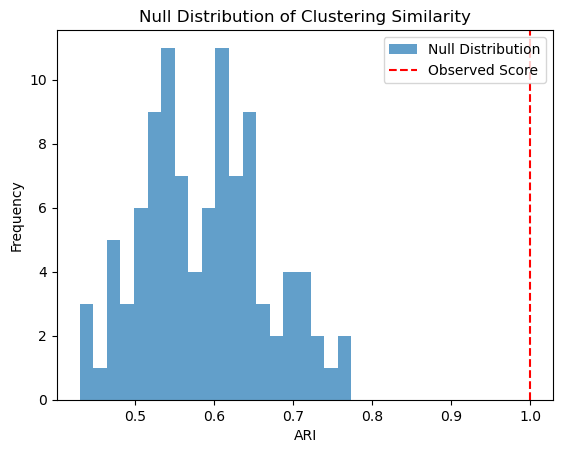

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [7]:
num_iterations = 100
n_clusters = 7
temp = deepcopy(processed_random_segments_fft)
null_scores, observed_score, null_affinities, observed_affinity = compute_null_distribution(
    temp,
    ground_truth=None,
    n_clusters=n_clusters,
    num_iterations=num_iterations
)

visualize_null_distribution(null_scores, observed_score)

for a in null_affinities:
    print(are_matrices_permutations_eigen(a.toarray(), observed_affinity.toarray()))

In [8]:
def compute_affinity_matrix(X, n_neighbors=10):
    knn_graph = kneighbors_graph(X, n_neighbors, include_self=True, n_jobs=-1)
    affinity_matrix = knn_graph.toarray()
    # Ensure the affinity matrix is symmetric
    affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)
    return affinity_matrix

def spectral_clustering_workflow(processed_segments, n_clusters=5, source='fft'):
    if source == 'fft':
        magnitudes = np.array([segment['interpolated_fft_magnitude'] for segment in processed_segments])
    else:
        magnitudes = np.array([np.vstack(segment['padded_power_levels']).flatten() for segment in processed_segments])
    
    scaler = StandardScaler()
    magnitudes_scaled = scaler.fit_transform(magnitudes)
    
    affinity_matrix = compute_affinity_matrix(magnitudes_scaled)
    
    spectral_clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        random_state=42,
        n_init=10
    )
    labels = spectral_clustering.fit_predict(affinity_matrix)
    
    for i, segment in enumerate(processed_segments):
        segment['cluster'] = labels[i]
    
    clusters = defaultdict(list)
    for segment in processed_segments:
        clusters[segment['cluster']].append(segment)
    
    return clusters, affinity_matrix

def shuffle_segments(processed_segments, seed):
    rng = np.random.default_rng(seed)
    shuffled_segments = deepcopy(processed_segments)
    rng.shuffle(shuffled_segments)
    return shuffled_segments

def are_matrices_permutations_graph(matrix1, matrix2):
    # Ensure the matrices are square and of the same size
    if matrix1.shape != matrix2.shape or matrix1.shape[0] != matrix1.shape[1]:
        return False
    
    # Create graph representations
    G1 = nx.from_numpy_matrix(matrix1)
    G2 = nx.from_numpy_matrix(matrix2)
    
    # Check for graph isomorphism
    return nx.is_isomorphic(G1, G2)


def run_permutation_experiment(processed_segments, n_clusters=5, num_permutations=10, source='fft'):
    # Compute baseline results
    baseline_clusters, baseline_affinity_matrix = spectral_clustering_workflow(processed_segments, n_clusters, source)
    baseline_labels = [segment['cluster'] for segment in processed_segments]
    
    perm_affinity_checks = []
    perm_nmi_scores = []

    for i in range(num_permutations):
        shuffled_segments = shuffle_segments(processed_segments, seed=i)
        perm_clusters, perm_affinity_matrix = spectral_clustering_workflow(shuffled_segments, n_clusters, source)
        perm_labels = [segment['cluster'] for segment in shuffled_segments]
        
        # Check if affinity matrices are permutations of each other
        are_permutations = are_matrices_permutations_eigen(baseline_affinity_matrix, perm_affinity_matrix)
        perm_affinity_checks.append(are_permutations)
        
        # Compare clustering results
        score = adjusted_rand_score(baseline_labels, perm_labels)
        perm_nmi_scores.append(score)

    # Count how many times the matrices were found to be permutations of each other
    num_permutations_equal = sum(perm_affinity_checks)
    
    print(f'Number of permutations where affinity matrices are equal: {num_permutations_equal} out of {num_permutations}')

    # Plot NMI scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_permutations), perm_nmi_scores, marker='o')
    plt.xlabel('Permutation Index')
    plt.ylabel('AIR Score')
    plt.title('ARI Scores Across Permutations')
    plt.tight_layout()
    plt.show()

    # Print average NMI score
    avg_nmi = np.mean(perm_nmi_scores)
    print(f'Average ARII Score Across Permutations: {avg_nmi}')

    return perm_affinity_checks, perm_nmi_scores

Number of permutations where affinity matrices are equal: 100 out of 100


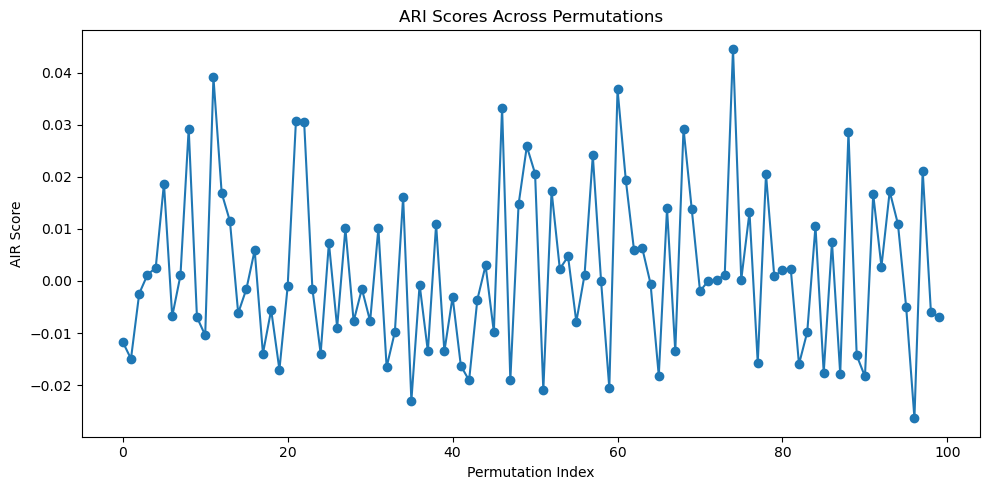

Average ARII Score Across Permutations: 0.0018843277049662324


([True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 [-0.011698721322281643,
  -0.014953444911974716,
  -0.002423155468617004,
  0.0011866086180856133,
  0.0025150231794337967,
  0.018698862042328488,
  -0.006814430244095294,
  0.0010513074921867005,


In [9]:
temp = deepcopy(processed_random_segments_fft)
processed_segments = temp # Your processed segments data
num_permutations = 100
n_clusters = 7
run_permutation_experiment(processed_segments, n_clusters, num_permutations)


Original Data:
[[0.13101462 0.60095719]
 [0.0342979  0.49756608]
 [0.15484268 0.18292293]
 [0.36504757 0.43243717]
 [0.62317242 0.07442842]
 [0.50369176 0.18262513]
 [0.57397518 0.63740461]
 [0.55670926 0.73829551]
 [0.5        0.5       ]
 [0.5        0.5       ]]


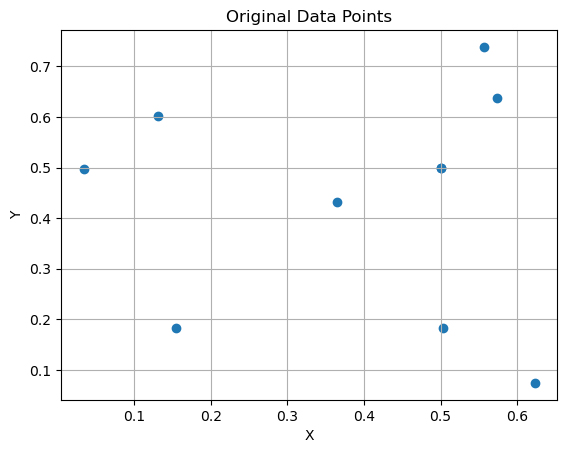

In [10]:
data = np.random.rand(10, 2)  # 10 points in 2D space

# Introduce some points with the same distance
data[8] = [0.5, 0.5]  # Point in the center
data[9] = [0.5, 0.5]  # Duplicate point in the center

print("Original Data:")
print(data)

# Plot the original data points
plt.scatter(data[:, 0], data[:, 1])
plt.title("Original Data Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

In [11]:
a1 = np.array([
    [1,0.5,0.7],
    [0.5,1,0.2],
    [0.7,0.2,1]
])

a2 = np.array([
    [1,0.2,0.7],
    [0.2,1,0.5],
    [0.7,0.5,1]
])

a3 = np.array([
    [1,0.2,0.5],
    [0.2,1,0.7],
    [0.5,0.7,1]
])



print(are_matrices_permutations_eigen(a1, a2))
print(are_matrices_permutations_eigen(a2, a3))
print(are_matrices_permutations_eigen(a1, a3))

True
True
True


In [12]:
def get_D_L(mat):
    # Compute the degree matrix D
    D = np.diag(np.sum(mat, axis=1))
    
    # Compute the Laplacian matrix L
    L = D - mat
    
    return D, L

d1, l1 = get_D_L(a1)
d2, l2 = get_D_L(a2)
d3, l3 = get_D_L(a3)

def smallest_k_eigen(L, k):
    eigenvalues, eigenvectors = eigh(L)
    
    # Smallest two eigenvalues
    smallest_eigenvalues = eigenvalues[:k]
    
    # Corresponding eigenvectors
    corresponding_eigenvectors = eigenvectors[:, :k]
    
    return smallest_eigenvalues, corresponding_eigenvectors

eigenvalues_a1, eigenvectors_a1 = smallest_k_eigen(l1, 3)
eigenvalues_a2, eigenvectors_a2 = smallest_k_eigen(l2, 3)
eigenvalues_a3, eigenvectors_a3 = smallest_k_eigen(l3, 3)

print(eigenvalues_a1)
print(eigenvectors_a1)

print(eigenvalues_a2)
print(eigenvectors_a2)

print(eigenvalues_a3)
print(eigenvectors_a3)

[-2.22044605e-16  9.64110106e-01  1.83588989e+00]
[[-0.57735027  0.1656674   0.79951296]
 [-0.57735027 -0.77523224 -0.2562843 ]
 [-0.57735027  0.60956484 -0.54322866]]
[8.88178420e-16 9.64110106e-01 1.83588989e+00]
[[ 0.57735027  0.60956484  0.54322866]
 [ 0.57735027 -0.77523224  0.2562843 ]
 [ 0.57735027  0.1656674  -0.79951296]]
[1.33226763e-15 9.64110106e-01 1.83588989e+00]
[[-0.57735027  0.77523224 -0.2562843 ]
 [-0.57735027 -0.60956484 -0.54322866]
 [-0.57735027 -0.1656674   0.79951296]]


In [13]:
def compute_knn_graph(data, n_neighbors=3):
    # Compute k-nearest neighbors graph
    knn_graph = kneighbors_graph(data, n_neighbors=n_neighbors, include_self=True, n_jobs=-1)
    affinity_matrix = knn_graph.toarray()
    # Ensure the affinity matrix is symmetric
    affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)
    return affinity_matrix

# Compute the affinity matrix for the original data
original_affinity_matrix = compute_knn_graph(data)

print("Original Affinity Matrix:")
print(original_affinity_matrix)

Original Affinity Matrix:
[[1.  1.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  1.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.5 1.  0.5 0.5 0.  0.  1.  1. ]
 [0.  0.  0.  0.5 1.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 1.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  1.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  1.  1.  0.5 0. ]
 [0.  0.  0.  1.  0.  0.  0.5 0.5 1.  1. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  1.  1. ]]


In [14]:
def shuffle_data(data, seed):
    rng = np.random.default_rng(seed)
    shuffled_data = deepcopy(data)
    rng.shuffle(shuffled_data)
    return shuffled_data

# Shuffle data and compute affinity matrices multiple times
num_permutations = 5
affinity_matrices = []
differences = []

for i in range(num_permutations):
    shuffled_data = shuffle_data(data, seed=i)
    shuffled_affinity_matrix = compute_knn_graph(shuffled_data)
    affinity_matrices.append(shuffled_affinity_matrix)
    
    # Compute difference with the original affinity matrix
#     diff = np.mean(np.abs(original_affinity_matrix - shuffled_affinity_matrix))
    diff = are_matrices_permutations_eigen(original_affinity_matrix, shuffled_affinity_matrix)
    differences.append(diff)
    
    # Print or visualize the shuffled data and affinity matrix
    print(f"Shuffled Data {i+1}:")
    print(shuffled_data)
    
    print(f"Shuffled Affinity Matrix {i+1}:")
    print(shuffled_affinity_matrix)
    
    print(f"Difference with Original: {diff}")

# Plot differences
# plt.plot(range(num_permutations), differences, marker='o')
# plt.xlabel('Permutation Index')
# plt.ylabel('Difference from Original Affinity Matrix')
# plt.title('Differences in Affinity Matrices Across Permutations')
# plt.show()

print(differences)

# Check if any affinity matrices are identical to the original
are_identical = [np.allclose(original_affinity_matrix, am) for am in affinity_matrices]
print(f'Are any affinity matrices identical to the original? {any(are_identical)}')

Shuffled Data 1:
[[0.62317242 0.07442842]
 [0.57397518 0.63740461]
 [0.15484268 0.18292293]
 [0.55670926 0.73829551]
 [0.36504757 0.43243717]
 [0.50369176 0.18262513]
 [0.5        0.5       ]
 [0.13101462 0.60095719]
 [0.5        0.5       ]
 [0.0342979  0.49756608]]
Shuffled Affinity Matrix 1:
[[1.  0.  0.  0.  0.5 1.  0.  0.  0.  0. ]
 [0.  1.  0.  1.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  1.  0.  0.5 0.  0.  0.  0.  1. ]
 [0.  1.  0.  1.  0.  0.  0.5 0.  0.  0. ]
 [0.5 0.  0.5 0.  1.  0.5 1.  0.5 1.  0. ]
 [1.  0.  0.  0.  0.5 1.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.5 1.  0.  1.  0.  1.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  1.  0.  1. ]
 [0.  0.  0.  0.  1.  0.  1.  0.  1.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  1.  0.  1. ]]
Difference with Original: True
Shuffled Data 2:
[[0.5        0.5       ]
 [0.62317242 0.07442842]
 [0.55670926 0.73829551]
 [0.13101462 0.60095719]
 [0.0342979  0.49756608]
 [0.15484268 0.18292293]
 [0.50369176 0.18262513]
 [0.5        0.5       ]
 [0.57397518 0.63740461]
